# Generalized Linear Models using pynapple & nemos
In this notebook, we will use nemos and pynapple packages (supported by the [Flatiron Institute](https://neurorse.flatironinstitute.org)), to model spiking neural data using [Generalized Linear Models (GLM)](https://en.wikipedia.org/wiki/Generalized_linear_model). We will explain what a GLM is and which are it's components, and then use pynapple and nemos libraries to preprocess real data from the Allen Institute and use a GLM model to predict spiking neural data as a function of stimuli.

##### Data
We will be analyzing data from the [Visual Coding - Neuropixels dataset](https://portal.brain-map.org/circuits-behavior/visual-coding-neuropixels), published by the Allen Institute. This dataset uses [extracellular electrophysiology probes](https://www.nature.com/articles/nature24636) to record spikes from multiple regions in the brain during passive visual stimulation. For simplicity, we will focus on the activity of neurons in the visual cortex (VISp) during passive visual stimulation: full-field flashes, of color either black or white. 

##### Objective
Our aim is to model spiking activity from neurons (spiking rates and spike trains) as a function of the presented stimuli. Moreover, we will also compare this model including an extra predictor: spike history, to see whether adding history as a predictor improves the performance of the model.

##### What is a GLM?

A GLM is a regression model which trains a filter to predict single neuron activity as it relates to some other variable. It is called "generalized" because it constitutes a generalization of [ordinary linear regression](https://en.wikipedia.org/wiki/Linear_regression). Ordinary linear regression assumes a constant change in a predictor leads to a constant change in the response variable, but this assumption is no longer useful for some types of response variables. In particular, when interested in modeling spikes, these are never expected to be negative! Thus, if interested in modeling this kind of phenomena, the model of choice must account for this restriction.

In the neuroscience context, a GLM can be thought of as a LNP model: linear-nonlinear-Poisson model.
<figure>
<img src="../../data/images/lnp_model.svg" style="width:130%"/>
<figcaption align = "center"> LNP model schematic. Modified from <a href="https://www.nature.com/articles/nature07140">Pillow et al., 2008</a></figcaption>
</figure>
 That is, the model receives one or more inputs and then:
<!-- 
%1. Sends it through a linear filter or transformation
#2. Passes the transformation through a nonlinearity to obtain a firing rate
#3. Uses the firing rate as the mean of a Poisson process to generate spikes
We will briefly go through each step one by one.
 -->

##### 1. Sends them through a linear filter or transformation
The input (s) (also known as "predictor(s)") are first passed through a linear transformation:  

 $WX + c$

This scales (makes bigger or smaller) or shifts (up or down) the input. When there is zero input, this is equivalent to changing the baseline rate of the neuron, which is how the intercept should be interpreted. So far, this is the same treatment of an ordinary linear regression. 

##### 2. Passes the transformation through a nonlinearity to obtain a firing rate
However, the aim of a GLM is to predict spiking activity. In particular, to predict a neuron's firing rate, which must be non-negative. This, as mentioned, is what the non-linearity part of the model handles: by passing the linear transformation through an exponential function, it is assured that it will always be non-negative. 

As such, the firing rate, according to GLMs, would be defined as:

 $\lambda =  exp(WX + c)$

##### 3. Uses the firing rate as the mean of a Poisson process to generate spikes
A Poisson process is a special type of point process, in which the events are statistically independent. With these type of GLMs, each spike train is a sample from a Poisson process with the mean equal to the firing rate, i.e., output of the linear-nonlinear parts of the model. 

Remember, spiking is a stochastic process. That means that a given firing rate can give rise to a variety of different spike trains. Given that this is a stochastic process that could produce an infinite number of possible spike trains, how do we compare our model against the single observed spike train we have? We use the log-likelihood. This quantifies how likely it is to observe the given spike train for the computed firing rate: if $y(t)$ is the spike counts and $\lambda(t)$ the firing rate, the equation for the log-likelihood is

$\sum_{t}logP(y(t)|\lambda(t) = \sum_{t}y(t)log(\lambda(t))) - \lambda(t) - log(y(t)!)$

##### More resources
If you would like to learn more in depth about GLMs, you can refer to
- [Nemos GLM tutorial](https://nemos.readthedocs.io/en/latest/background/plot_00_conceptual_intro.html): for a bit more detailed explanation of all the components of a GLM within the nemos framework, as well as some nice visualizations of all the steps of the input transformation!
- Short Medium artil
Formally, a GLM is a model for which $y$ is a non-linear function of a linear combination of the input variables so that

$y = f(wx+w_0)$,

where $f(.)$ is known as the activation function in machine learning literature and $f^{-1}(.)$ is known as the link function in statistics [(Bishop, 2009)](https://www.microsoft.com/en-us/research/wp-content/uploads/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf).


NOTE: In NeMoS, the non-linearity is kept fixed. We default to the exponential, but a small number of other choices, such as soft-plus, are allowed. The allowed choices guarantee both the non-negativity constraint described above, as well as convexity, i.e. a single optimal solution. In principle, one could choose a more complex non-linearity, but convexity is not guaranteed in general.


Pending:
- Present functions in a way that makes logical sense with the rest of the code
- Comment all functions
- Write explanations in markdown for all steps
- Find citations
- Revise again that the current way of storing stimuli for modeling (np.array) is indeed the best one
- Organize your imports bro
- Make id's consistent between units
- For perievents: maybe split neurons by firing rate? that would allow for the smaller firing rate ones not to be lost when compared to the large firing rate ones

q: responsiveness is currently being calculated as diff av fr before stimulus presentation and during presentation - should it be before and after instead?

what's the difference between using simulate and predict?



### Learning objectives
- Identify the steps in the process of fitting individual neural data using a GLM
- 
- 

Estimated time of completion: X minutes

- Add questions to ask self when completing the notebook for comprehension? With links to answers somewhere else?
So far, we have focused on the relatively simple LNP model of spike generation, which is a special case of a GLM. The LNP model has some known shortcomings. For instance, LNP ignores things like refactory periods and other history-dependent features of spiking in a neuron. As we will show in other demos, such spike history filters can be built into GLMs to give more accurate results. We will also show how, if you have recordings from a large population of neurons simultaneously, you can build connections between the neurons into the GLM in the form of coupling filters. This can help answer the degree to which activity is driven primarily by the input X, or by network influences in the population. [from nemos - adapt]

Questions for reflection?
- What are some important limitations of this model?


### Create Environment and Download Dependencies

In [34]:
'''
import warnings
warnings.filterwarnings('ignore')

try:
    from databook_utils.dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

'''

"\nimport warnings\nwarnings.filterwarnings('ignore')\n\ntry:\n    from databook_utils.dandi_utils import dandi_download_open\nexcept:\n    !git clone https://github.com/AllenInstitute/openscope_databook.git\n    %cd openscope_databook\n    %pip install -e .\n\n"

pending to organize imports

In [35]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import jax
import pynapple as nap
import nemos as nmo

from math import ceil
from scipy import interpolate
from functools import reduce
from scipy.optimize import minimize
from sklearn.metrics import r2_score
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
from glm_utils import *

### Download data

Should we download using nemos or dandi?

In [36]:
# Download dataset using nemos

# Dataset information
dandiset_id = "000021"
dandi_filepath = "sub-726298249/sub-726298249_ses-754829445.nwb"
download_loc = "."

# Download NEMOS 
# io = nmo.fetch.download_dandi_data(dandiset_id, dandi_filepath)
# nap_nwb = nap.NWBFile(io.read(), lazy_loading=True)

In [37]:
# Now we have th data - very simple (: Open dataset with Pynapple
path = "sub-726298249_ses-754829445.nwb"
data = nap.load_file(path)
nwb = data.nwb

/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


admonition - pynapple documentation | check syntax nemos. here we can see four type of objects
- tsgroup: sdfdf
- interval set: sfsdf
- :sdfjnsjkfn

To learn more blabla

In [38]:
data

sub-726298249_ses-754829445
┍━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys                                               │ Type        │
┝━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ units                                              │ TsGroup     │
│ static_gratings_presentations                      │ IntervalSet │
│ spontaneous_presentations                          │ IntervalSet │
│ natural_scenes_presentations                       │ IntervalSet │
│ natural_movie_three_presentations                  │ IntervalSet │
│ natural_movie_one_presentations                    │ IntervalSet │
│ gabors_presentations                               │ IntervalSet │
│ flashes_presentations                              │ IntervalSet │
│ drifting_gratings_presentations                    │ IntervalSet │
│ timestamps                                         │ Tsd         │
│ running_wheel_rotation                             │ Tsd         │
│ runn

In [ ]:
units = data["units"]
print(units)
# bunch of data we dont need

Index      rate      spread    velocity_below    silhouette_score    firing_rate    d_prime    nn_hit_rate    ...
---------  --------  --------  ----------------  ------------------  -------------  ---------  -------------  -----
951763702  2.38003   30.0      nan               nan                 2.38           4.77       0.98           ...
951763707  0.01147   80.0      nan               0.03                0.01           3.48       0.0            ...
951763711  3.1503    50.0      nan               0.17                3.15           6.08       1.0            ...
951763715  6.53      40.0      nan               0.12                6.53           5.04       0.99           ...
951763720  2.00296   40.0      0.0               0.2                 2.0            6.45       0.99           ...
951763724  8.66233   60.0      -7.55             0.22                8.66           3.1        0.86           ...
951763729  11.13402  30.0      -0.69             0.01                11.13          4.

In [ ]:
# drop the data i dont need

In [ ]:
#Here we dont have the brain area but we need it -> need to do blabla to extract brain area from metadata | extract

In [40]:
# Units and brain areas those units belong to are in two different places. With the electrodes table, we can map units to their corresponding brain regions.
def get_unit_location(unit_id):
    """Aligns location information from electrodes table with channel id from the units table
    """
    return channel_probes[int(units[unit_id].peak_channel_id)]

channel_probes = {}
electrodes = nwb.electrodes

for i in range(len(electrodes)):
    channel_id = electrodes["id"][i]
    location = electrodes["location"][i]
    channel_probes[channel_id] = location
    
# Add a new column to include location in our spikes TsGroup
units.brain_area = [channel_probes[int(ch_id)] for ch_id in units.peak_channel_id]

In [41]:
units

Index      rate      spread    velocity_below    silhouette_score    firing_rate    d_prime    nn_hit_rate    ...
---------  --------  --------  ----------------  ------------------  -------------  ---------  -------------  -----
951763702  2.38003   30.0      nan               nan                 2.38           4.77       0.98           ...
951763707  0.01147   80.0      nan               0.03                0.01           3.48       0.0            ...
951763711  3.1503    50.0      nan               0.17                3.15           6.08       1.0            ...
951763715  6.53      40.0      nan               0.12                6.53           5.04       0.99           ...
951763720  2.00296   40.0      0.0               0.2                 2.0            6.45       0.99           ...
951763724  8.66233   60.0      -7.55             0.22                8.66           3.1        0.86           ...
951763729  11.13402  30.0      -0.69             0.01                11.13          4.

We dont care about all the metadata

### Extracting Spiking Data

In [6]:
# There are many columns in this dataset which are not relevant to our goals so we can remove them.
def drop_cols(cols_to_keep, data):
    print(f"Previous columns {data.metadata_columns}")
    cols_to_remove = [col for col in data.metadata_columns if col not in cols_to_keep]
    data.drop_info(cols_to_remove)
    print(f"New columns after drop {data.metadata_columns}")

In [ ]:
# There are many columns in this dataset which are not relevant to our goals so we can remove them.
cols_to_keep = ['rate', 'quality', 'brain_area', 'peak_channel_id']
drop_cols(cols_to_keep,units)

# Add a new column to include location in our spikes TsGroup
units["brain_area"] = units["peak_channel_id"].map(channel_probes)



Previous columns ['rate', 'spread', 'velocity_below', 'silhouette_score', 'firing_rate', 'd_prime', 'nn_hit_rate', 'waveform_duration', 'amplitude', 'cluster_id', 'snr', 'local_index', 'peak_channel_id', 'PT_ratio', 'presence_ratio', 'max_drift', 'cumulative_drift', 'repolarization_slope', 'waveform_halfwidth', 'amplitude_cutoff', 'nn_miss_rate', 'quality', 'velocity_above', 'isolation_distance', 'l_ratio', 'recovery_slope', 'isi_violations', 'brain_area']
New columns after drop ['rate', 'peak_channel_id', 'quality', 'brain_area']


Index      rate      peak_channel_id    quality    brain_area
---------  --------  -----------------  ---------  ------------
951765440  9.97935   850135520          good       VISp
951765454  5.47349   850135526          good       VISp
951765460  4.44892   850135526          good       VISp
951765467  9.98162   850135528          good       VISp
951765478  17.40465  850135532          good       VISp
951765485  13.97731  850135532          good       VISp
951765508  2.13461   850135532          good       VISp
...        ...       ...                ...        ...
951768894  9.16155   850138328          good       VISp
951768901  3.99186   850138330          good       VISp
951768907  2.85765   850138332          good       VISp
951768925  2.28806   850138336          good       VISp
951769295  3.27275   850138270          good       VISp
951769299  4.57933   850138272          good       VISp
951769304  2.04729   850138274          good       VISp

explain

In [ ]:
# Filter units 1) in VISp, 2) with "good" quality and 3) with a firing rate larger than 2
units_visp = units[(units["brain_area"]=="VISp") & (units["quality"]=="good") & (units["rate"]>2.0)] 

units_visp

### Set up stimulus data

In [ ]:
# Extract flashes
flashes = data["flashes_presentations"]

# Remove unnecesary columns - we do the same thing
cols_to_keep = ['color']
drop_cols(cols_to_keep, flashes)

flashes

Previous columns ['stimulus_name', 'stimulus_block', 'color', 'mask', 'opacity', 'phase', 'size', 'units', 'stimulus_index', 'orientation', 'spatial_frequency', 'contrast', 'tags', 'timeseries']
New columns after drop ['color']


/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/pynapple/core/metadata_class.py:167: UserWarning: Metadata name 'size' overlaps with an existing attribute, and cannot be accessed as an attribute or key. Use 'get_info()' to access metadata.
  warnings.warn(


index    start           end             color
0        1285.600869922  1285.851080039  -1.0
1        1287.602559922  1287.852767539  -1.0
2        1289.604229922  1289.854435039  -1.0
3        1291.605889922  1291.856100039  -1.0
4        1293.607609922  1293.857807539  1.0
5        1295.609249922  1295.859455039  -1.0
6        1297.610959922  1297.861155039  1.0
...      ...             ...             ...
143      1571.840009922  1572.090212539  -1.0
144      1573.841669922  1574.091877539  1.0
145      1575.843359922  1576.093562539  1.0
146      1577.845019922  1578.095227539  -1.0
147      1579.846709922  1580.096915039  1.0
148      1581.848389922  1582.098595039  1.0
149      1583.850039922  1584.100247539  -1.0
shape: (150, 2), time unit: sec.

### Revision of stimuli and spiking

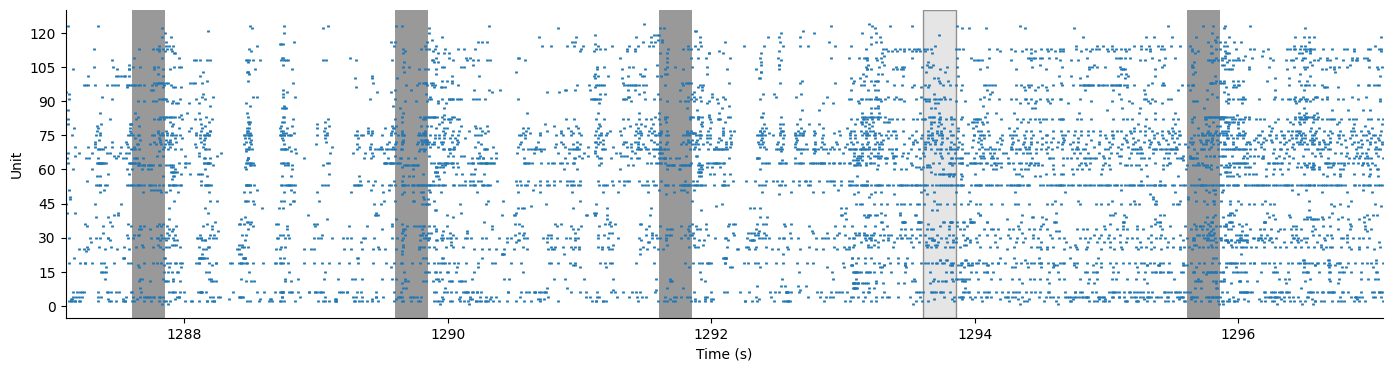

In [ ]:
# Plot settings
start = data["flashes_presentations"]["start"].min()
end = data["flashes_presentations"]["end"].max()

n_neurons = 124
n_flashes = 5
n_seconds = 10
offset = 1.5

# Get a subset of the tsgroup to compute perievents to plot 
units_to_include = units_visp.keys()[:n_neurons]
subset_neurons = units_visp[units_to_include]

# Restrict the neurons to the period of presentation fo stimuli
subset_neurons = subset_neurons.restrict(nap.IntervalSet(start, end)) # homogenize restricts

white_flashes = flashes[flashes["color"] == "1.0"]
black_flashes = flashes[flashes["color"] == "-1.0"]

# Change type to tsd to access spiking times. 
# Change the metadata information so each different neuron is now tagged with an ID from 1 to 10
neurons_to_plot = subset_neurons.to_tsd([i+1 for i in range(n_neurons)]) # Restrict to begin and end

fig, ax = plt.subplots(figsize = (17, 4))

ax.plot(neurons_to_plot, "|", markersize=2, mew=2)

# Different coloured flashes
[ax.axvspan(s, e, color = "silver", alpha=.4, ec="black") for s, e in zip(white_flashes[:n_flashes].start, white_flashes[:n_flashes].end)]
[ax.axvspan(s, e, color = "black", alpha=.4, ec=None) for s, e in zip(black_flashes[:n_flashes].start, black_flashes[:n_flashes].end)]

plt.xlabel("Time (s)")
plt.ylabel("Unit")
plt.xlim(start + offset, start + offset + n_seconds)

# Only use integer values for ticks
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# title visp

plt.show()

### Selecting most relevant units
Units can be excluded from analysis for various reasons. We've already filtered based on recording quality, firing rate (above 2 Hz), and brain area. However, in the context of GLM modeling, where the goal is to predict firing rate as a function of stimuli, we are now specifically interested in how neurons respond to white and/or black flashes.

To focus on meaningful signal, we will exclude units that show no spiking activity during stimulus presentation. Additionally, we will select the most responsive units for further analysis.

[I Should add some info on neurons that activate only when stimulus arent there] (?)

[I should explain here what a perievent is]

- Set START and END of analysis as start and end of stimuli. This dataset originally contained a lot more information of different stimuli, which is why the recording of spikes is a lot longer than flashes presentation. However, we are only interested in seeing the effect of white and black flashes in neural activity. 
- BIN_SIZE refers to the size of the "binning" of the time series. In that sense, a BIN_SIZE of 0.01 means that one second will be split into 100 bins. Larger bins indicate less temporal resolution, while smaller bins indicate larger temporal resolution.

In [ ]:
# object black and object white. create interval set with start and end 

In [ ]:
# Extract start times ts black and white 
#color_code = "1.0" if color == "white" else "-1.0"
#start_times = flashes[flashes["color"] == color_code]["start"]
#start_times_ts = nap.Ts(start_times)

this is how we extract a perievent blabla



In [ ]:
#perievent_black = nap.compute_perievent(
#            timestamps = subset_neurons, 
#            tref = start_times_b,
#            minmax=(min_peri, max_peri)
#        )    

In [ ]:
# raster plot perievent
# list of units that i want to plot
# diverse examples

In [ ]:
#perievent_black = nap.compute_perievent( # WHITE
#            timestamps = subset_neurons, 
#            tref = start_times_b,
#            minmax=(min_peri, max_peri)
#        )  

In [ ]:
bin_size = 0.01

# Get perievents
#peri_white, peri_black = extract_perievents(units_visp, flashes)

# Get average responsiveness
#responsive_white = get_responsiveness(peri_white, bin_size)
#responsive_black = get_responsiveness(peri_black, bin_size) # DELETE

# I can also restrict this in the flash presentation time <- restrict above in the first filter of units 
# Find units with average 0 responsiveness before
# and after stimulus presentation
units_to_remove_white = [
    k for k, v in responsive_white.items()
    if v.get("pre_stim_av") <= 0 and v.get("post_stim_av") <= 0
]
units_to_remove_black = [
    k for k, v in responsive_black.items()
    if v.get("pre_stim_av") <= 0 and v.get("post_stim_av") <= 0
]
units_to_remove = list(set(units_to_remove_white) & set(units_to_remove_black))

# Create subset only including relevant units for further analysis
units_to_keep = [unit for unit in units_visp.keys() if unit not in units_to_remove]
units_visp_subset = units_visp[units_to_keep]

/Users/camilamaura/coding_projects/openscope_databook/docs/higher-order/glm_utils.py:142: RuntimeWarning: invalid value encountered in scalar divide
  responsiveness = (post_stim_av - pre_stim_av) / (post_stim_av + pre_stim_av)


### Select most responsive units

Now we want to see whether the remaining neurons are in fact responsive to the presented stimuli. 

For this, we will select the most responsive units and plot a "perievent" (close to event).

For a rough estimate of responsiveness, we will use:
    
    FR[.1s] - FR[-1.s] / FR[.1s] + FR[-1.s]

(is there a citation for this?)

In [ ]:
#peri_white, peri_black = extract_perievents(units_visp_subset, flashes)

responsive_white = get_responsiveness(peri_white, bin_size)
top_keys_peri_white = get_top_responsive_units(responsive_white, units_visp_subset)

responsive_black = get_responsiveness(peri_black, bin_size)
top_keys_peri_black = get_top_responsive_units(responsive_black, units_visp_subset)

# All subsequent analyses will be carried out with this subset of neurons
top_neurons_white = units_visp_subset[top_keys_peri_white]
top_neurons_black = units_visp_subset[top_keys_peri_black]

/Users/camilamaura/coding_projects/openscope_databook/docs/higher-order/glm_utils.py:142: RuntimeWarning: invalid value encountered in scalar divide
  responsiveness = (post_stim_av - pre_stim_av) / (post_stim_av + pre_stim_av)


In [ ]:
# attach responsiveness as metadata so i can use as a filter later
# np.percentile -> top 30%

### Perievent

In [53]:
## Plot definition side by side
def plot_peri_side_by_side(params,
                           bin_sz,
                           simulation = False,
                           smoothing = 0.02):
    """ Top neurons should be range from 0 to last shape dim in case of simulation
    """
    peri_white, top_neurons_white, peri_black, top_neurons_black = params
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # 1 row, 2 columns

    # Plot White
    ax = axs[0]
    
    for unit in top_neurons_white:
        if simulation: 
            peri_u = np.mean(peri_white,axis=1)[:,unit]
            ax.plot(peri_u, linewidth=1)
        else:
            peri_u = peri_white[unit]
            peri_u_count = peri_u.count(bin_sz)

            peri_u_coun_conv_mean = np.mean(peri_u_count, 1).smooth(std=smoothing)
            peri_u_rate_conv = peri_u_coun_conv_mean / bin_sz
            ax.plot(peri_u_rate_conv, linewidth=1)
    

    ax.set_xlim(-0.25, 0.50) # restrict
    ax.axvspan(0, 0.250, color="silver", alpha=0.3, ec="black")
    ax.axvline(0.0, color="black")
    ax.set_ylabel("Firing rate (Hz)")
    ax.set_title("Perievent white flashes")

    # Plot Black
    ax = axs[1]
    for unit in top_neurons_black:
        if simulation: 
            peri_u = np.mean(peri_black,axis=1)[:,unit]
            ax.plot(peri_u, linewidth=1)
        else:
            peri_u = peri_black[unit]
            peri_u_count = peri_u.count(bin_sz)

            peri_u_coun_conv_mean = np.mean(peri_u_count, 1).smooth(std=smoothing)
            peri_u_rate_conv = peri_u_coun_conv_mean / bin_sz
            ax.plot(peri_u_rate_conv, linewidth=1)

    ax.set_xlim(-0.25, 0.50) # restrict
    ax.axvspan(0, 0.250, color="black", alpha=0.3, ec=None)
    ax.axvline(0.0, color="black")
    ax.set_title("Perievent black flashes")

    plt.tight_layout()
    plt.show()


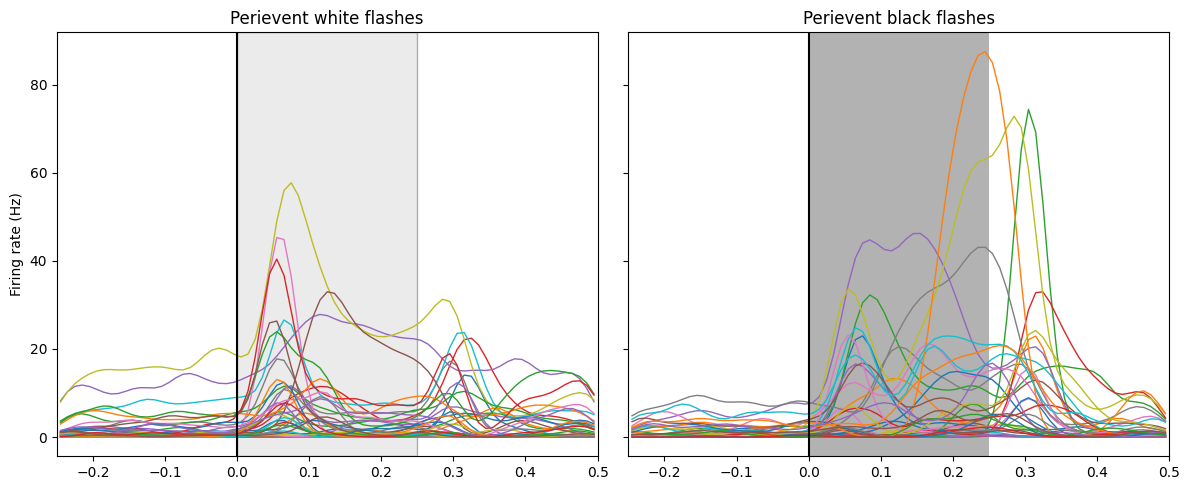

In [ ]:
# check transparency of plot line axvspan
bin_size = 0.01

params_obs = [peri_white, 
              top_keys_peri_white, 
              peri_black, 
              top_keys_peri_black
]

plot_peri_side_by_side(params_obs,
                       bin_size
)

These neurons spiking rate certainly seems modulated by the flashes presentation. Lets keep those for the following analyses.

Here I would put an explanation for the duration of the filter. Id actually say that maybe the filter should be a bit longer? at least according to the perievent plots. 

## Nemos: Fitting a GLM

Have to explain why I am using:
- Raised Cosine Log
- Conv

place cells tutorial for explanation of composition of bases

### Building the basis
- Why use a basis?


- It is good practice to split the data in two chunks: training and testing data. The first chunk is used to train the model; the second, to asses its performance. The reason why we do this is to accurately assess the performance of the model. If we train and evaluate the model in the same data, this results in a biased  model which will yield high accuracy in the dataset it was trained with, which won't be representative of it's performance on any other dataset.

- This splitting can be done in different ways. Here, we will take a chunk for trai is known as  "cross-validation" and there is no one-size-fits-all strategy for it, as the best strategy will depend on the type of data and the model. [continue]

In [ ]:
# Set number of time bins
length = int((end-start)//bin_size)

# Drop unnecessary metadata
drop_list = [k for k in units_visp_subset.metadata_columns if k != "rate"]
units_visp_subset.drop_info(drop_list)

In [71]:
dt = .250
start = flashes.start - dt
end = flashes.end + dt

new_flashes = nap.IntervalSet(start,end, metadata=flashes.metadata)
new_flashes


index    start           end             color
0        1285.350869922  1286.101080039  -1.0
1        1287.352559922  1288.102767539  -1.0
2        1289.354229922  1290.104435039  -1.0
3        1291.355889922  1292.106100039  -1.0
4        1293.357609922  1294.107807539  1.0
5        1295.359249922  1296.109455039  -1.0
6        1297.360959922  1298.111155039  1.0
...      ...             ...             ...
143      1571.590009922  1572.340212539  -1.0
144      1573.591669922  1574.341877539  1.0
145      1575.593359922  1576.343562539  1.0
146      1577.595019922  1578.345227539  -1.0
147      1579.596709922  1580.346915039  1.0
148      1581.598389922  1582.348595039  1.0
149      1583.600039922  1584.350247539  -1.0
shape: (150, 2), time unit: sec.

In [ ]:
new_flashes[::2]

index    start           end             color
0        1285.350869922  1286.101080039  -1.0
1        1289.354229922  1290.104435039  -1.0
2        1293.357609922  1294.107807539  1.0
3        1297.360959922  1298.111155039  1.0
4        1301.364289922  1302.114487539  1.0
5        1305.367609922  1306.117815039  1.0
6        1309.370979922  1310.121177539  1.0
...      ...             ...             ...
68       1557.578329922  1558.328530039  1.0
69       1561.581629922  1562.331845039  -1.0
70       1565.584999922  1566.335205039  -1.0
71       1569.588349922  1570.338552539  -1.0
72       1573.591669922  1574.341877539  1.0
73       1577.595019922  1578.345227539  -1.0
74       1581.598389922  1582.348595039  1.0
shape: (75, 2), time unit: sec.

In [ ]:
sum(new_flashes[::2].color=="1.0")

In [ ]:
# Define cutting points for train and test set
# 
DURATION = end-start
train_times = nap.IntervalSet(start, start + DURATION * .5) # rename -> train_epochs
test_times = nap.IntervalSet(start + DURATION * .5, end) # rename -> train_epochs

# expand stimulus epoch to pre and post stimulus interval
# pick one every two. counterbalance so we get equal amount of white and black

## TRAINING SET
# Create Tsd with timestamps corresponding to the desired time bins and bins sizes
spike_counts_visp_subset_train = units_visp_subset.count(bin_size, ep=train_times)

print(spike_counts_visp_subset_train) # spike_counts_train

Time (s)        951765440    951765454    951765460    951765467    951765478    ...
--------------  -----------  -----------  -----------  -----------  -----------  -----
1285.355869922  0            0            0            0            0            ...
1285.365869922  0            0            0            0            0            ...
1285.375869922  1            0            0            0            0            ...
1285.385869922  0            0            0            0            0            ...
1285.395869922  0            1            0            0            0            ...
1285.405869922  0            0            0            0            0            ...
1285.415869922  0            0            0            0            0            ...
...             ...          ...          ...          ...          ...          ...
1583.915039922  1            0            1            0            0            ...
1583.925039922  0            0            1            1       

In [ ]:
# uniform_train = nap.Tsd(t=spike_counts_visp_subset_train.t, d=np.ones(spike_counts_visp_subset_train.shape[0]))

## TEST SET
spike_counts_visp_subset_test = units_visp_subset.count(bin_size, ep=test_times)
# uniform_test = nap.Tsd(t=spike_counts_visp_subset_test.t, d=np.ones(spike_counts_visp_subset_test.shape[0]))

# Split flashes interval set into train and rest
flashes_train = flashes[flashes.end<=uniform_train.end] # remove because now flashes will be first
flashes_test = flashes[flashes.start>uniform_train.end]

# For each desired timestamp, find the index of the flash interval it falls into.
# Returns NaN for timestamps outside all intervals, and an index for those within.
features_train = flashes_train.in_interval(uniform_train) # these i can restrict 
features_test = flashes_test.in_interval(uniform_test)

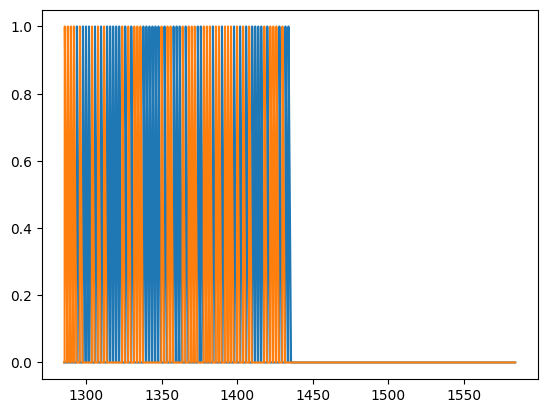

In [111]:
features = nap.TsdFrame(t=spike_counts_visp_subset_train.t, d=np.zeros((len(spike_counts_visp_subset_train), 2)), columns = ['white', 'black'])

idx_ep_1 = flashes_train[flashes_train.color=="1.0"].in_interval(spike_counts_visp_subset_train)

idx_ep_m1 = flashes_train[flashes_train.color=="-1.0"].in_interval(spike_counts_visp_subset_train)

features.d[~np.isnan(idx_ep_1), 0] = 1
features.d[~np.isnan(idx_ep_m1), 1] = 1
#print(s)
#print(features)

plt.plot(features)
#features.restrict(flashes_train[flashes_train.color=="-1.0"])

#$t = spike_counts_visp_subset_train.t[~np.isnan(uniform_train)]


#flashes_train.color[idx_ep[~np.isnan(idx_ep)]] 
#niform_train.t[~np.isnan(uniform_train)]

In [ ]:
# show sanity check plot to make sure that features match original stimuli

In [82]:
features_train[~np.isnan(features_train)]

array([ 0.,  0.,  0., ..., 74., 74., 74.])

problem: make sure train and test set arrays contain the right information & that they are aligned

In [ ]:
def retrieve_stim_info(color_code, features, flashes):
    """Retrieve stimulus information based on color code.

    Parameters
    ----------
    color_code : 
        The color label (e.g., '-1.0' for black, '1.0 for white) to identify the stimulus.
    features : 
        An array indicating which flash interval each timestamp belongs to.

    Returns
    ----------
    color_feature: 
        A binary array where 1 indicates the timestamp falls within a flash 
        interval of the given color_code, and 0 otherwise.
    """
    # Get the indices of flash intervals where the color matches the given color_code
    intervals = flashes.index[flashes["color"] == color_code]
    # Initialize an array of zeros with the same length as the features array
    color_feature = np.zeros(len(features))
    # Create a boolean mask for entries in 'features' that match the target flash intervals
    mask = np.isin(features, intervals)
    # Mark the matching timestamps with 1
    color_feature[mask] = 1

    return color_feature

In [17]:
white_stimuli_train = retrieve_stim_info("1.0", features_train, flashes_train)
black_stimuli_train = retrieve_stim_info("-1.0", features_train, flashes_train)

white_stimuli_test = retrieve_stim_info("1.0", features_test, flashes_test)
black_stimuli_test = retrieve_stim_info("-1.0", features_test, flashes_test)

In [18]:
tsd_white_train = nap.Tsd(t = spike_counts_visp_subset_train.t, d = white_stimuli_train)
tsd_black_train = nap.Tsd(t = spike_counts_visp_subset_train.t, d = black_stimuli_train)

tsd_white_test = nap.Tsd(t = spike_counts_visp_subset_test.t, d = white_stimuli_test)
tsd_black_test = nap.Tsd(t = spike_counts_visp_subset_test.t, d = black_stimuli_test)


In [ ]:
# Create basis for training
window_length = int(0.25 / bin_size)

bas = nmo.basis.RaisedCosineLogConv(n_basis_funcs = 5, window_size = window_length, label = "w") + nmo.basis.RaisedCosineLogConv(n_basis_funcs = 5, window_size = window_length, label = "b")

X_train = bas.compute_features(tsd_white_train, tsd_black_train)
X_test = bas.compute_features(tsd_white_test, tsd_black_test)

/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'ArrayImpl'.
  warnings.warn(
/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'ArrayImpl'.
  warnings.warn(
/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'ArrayImpl'.
  warnings.warn(
/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'ArrayImpl'.
  warnings.warn(


### Fitting the model

As mentioned before, we will use most responsive neurons for black and white stimuli for fitting.

As such, we will select only neurons on the top 30% responsiveness in at least one stimulus

are the top responsive neurons the same? are they different? (selective to one stimuli only)

In [ ]:
top_neurons_both = sorted(list(set(top_neurons_black.keys()) | set(top_neurons_white.keys())))

# Use most resposive neurons
units_visp_subset_top = units_visp_subset[top_neurons_both]

# Split in test and train
spikes_visp_subset_top_count_train = units_visp_subset_top.count(bin_size, ep=train_times)
spikes_visp_subset_top_count_test = units_visp_subset_top.count(bin_size, ep=test_times)

In [21]:
reg_strength = 0.01 #This should be checked with cross validation

model_base = nmo.glm.PopulationGLM(
    regularizer = "Ridge",
    regularizer_strength = reg_strength,
    solver_name="LBFGS", 
    solver_kwargs=dict(tol=10**-12))

model_base.fit(
    X_train,
    spikes_visp_subset_top_count_train
)

PopulationGLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=Ridge(),
    regularizer_strength=0.01,
    solver_name='LBFGS',
    solver_kwargs={'tol': 1e-12}
)

## Nemos: evaluating GLM
To assess whether the glm captures the data, let's predict spike rates.

I'll plot the rates in a perievent time histogram, so we can see whether the activity matches the observed patterns

### Perievent

In [ ]:
pred_pop = model_base.predict(X_test)
# convert units from spikes/bin to spikes/sec
pred_pop = pred_pop/ bin_size

pred_tsd_pop = nap.TsdFrame(t=spikes_visp_subset_top_count_test.t, d=pred_pop)

peri_white_sim, peri_black_sim = extract_perievents(pred_tsd_pop, flashes_test, continuous=True) 

# Excluding last trial from matrix because the last stimulus presented
# was a black one and after it's presented the time series is cut so
# it's all nans
peri_black_sim_new  = peri_black_sim[:,:-1,:]

/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'TsdFrame'.
  warnings.warn(


In [23]:
params_sim = [peri_white_sim,
              range(peri_white_sim.shape[2]),
              peri_black_sim_new,
              range(peri_black_sim.shape[2])
              ]

peri_white_test, peri_black_test = extract_perievents(units_visp_subset_top.restrict(test_times), flashes_test)

params_obs_test = [peri_white_test,
                   top_keys_peri_white,
                   peri_black_test,
                   top_keys_peri_black
            ]

In [24]:
'''plot_peri_side_by_side(params_sim,
                       BIN_SIZE,
                       simulation=True
)'''

'plot_peri_side_by_side(params_sim,\n                       BIN_SIZE,\n                       simulation=True\n)'

In [25]:
def plot_peri_both(params_obs,
                   params_sim,
                   bin_sz,
                   simulation = False,
                   smoothing = 0.02,
                   n_cells = 5):
    """ Top neurons should be range from 0 to last shape dim in case of simulation
    """
    peri_white_obs, top_neurons_white_obs, peri_black_obs, top_neurons_black_obs = params_obs
    peri_white_sim, top_neurons_white_sim, peri_black_sim, top_neurons_black_sim = params_sim

    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # 1 row, 2 columns

    # Plot White
    ax = axs[0]
    
    # Set colors obs
    n_lines = len(top_neurons_white_obs)

    cmap_obs = mpl.colormaps['Blues']
    colors_obs = cmap_obs(np.linspace(0.5, 1, n_lines))

    # Set colors sim
    cmap_sim = mpl.colormaps['Reds']
    colors_sim = cmap_sim(np.linspace(0.5, 1, n_lines))

    label_sim_added = False
    label_obs_added = False

    for unit_sim, unit_obs in enumerate(top_neurons_white_obs[:n_cells]):
        peri_u_sim = np.mean(peri_white_sim,axis=1)[:,unit_sim]
        if not label_sim_added:
            ax.plot(peri_u_sim, linewidth=1, color = colors_sim[unit_sim], label = "Simulated")
            label_sim_added = True
        else: 
            ax.plot(peri_u_sim, linewidth=1, color = colors_sim[unit_sim])
    
        peri_u_obs = peri_white_obs[unit_obs]
        peri_u_count_obs = peri_u_obs.count(bin_sz)
        peri_u_count_conv_mean_obs = np.mean(peri_u_count_obs, 1).smooth(std=smoothing)
        peri_u_rate_conv_obs = peri_u_count_conv_mean_obs / bin_sz
        if not label_obs_added:
            ax.plot(peri_u_rate_conv_obs, linewidth=1, color = colors_obs[unit_sim], label="Observed")
            label_obs_added = True
        else:
            ax.plot(peri_u_rate_conv_obs, linewidth=1, color = colors_obs[unit_sim])

    ax.set_xlim(-0.25, 0.50)
    ax.axvspan(0, 0.250, color="silver", alpha=0.3, ec=None)
    ax.axvline(0.0, color="black")
    ax.set_ylabel("Firing rate (Hz)")
    ax.set_title("Perievent white flashes")

    label_sim_added = False
    label_obs_added = False

    # Plot Black
    ax = axs[1]
    for unit_sim, unit_obs in enumerate(top_neurons_black_obs[:n_cells]):
        peri_u_sim = np.mean(peri_black_sim,axis=1)[:,unit_sim]
        if not label_sim_added:
            ax.plot(peri_u_sim, linewidth=1, color = colors_sim[unit_sim], label = "Simulated")
            label_sim_added = True
        else: 
            ax.plot(peri_u_sim, linewidth=1, color = colors_sim[unit_sim])


        peri_u_obs = peri_black_obs[unit_obs]
        peri_u_count_obs = peri_u_obs.count(bin_sz)
        peri_u_count_conv_mean_obs = np.mean(peri_u_count_obs, 1).smooth(std=smoothing)
        peri_u_rate_conv_obs = peri_u_count_conv_mean_obs / bin_sz
        if not label_obs_added:
            ax.plot(peri_u_rate_conv_obs, linewidth=1, color = colors_obs[unit_sim], label="Observed")
            label_obs_added = True
        else:
            ax.plot(peri_u_rate_conv_obs, linewidth=1, color = colors_obs[unit_sim])

    ax.set_xlim(-0.25, 0.50)
    ax.axvspan(0, 0.250, color="black", alpha=0.3, ec=None)
    ax.axvline(0.0, color="black")
    ax.set_title("Perievent black flashes")

    plt.tight_layout()
    plt.legend()
    plt.show()

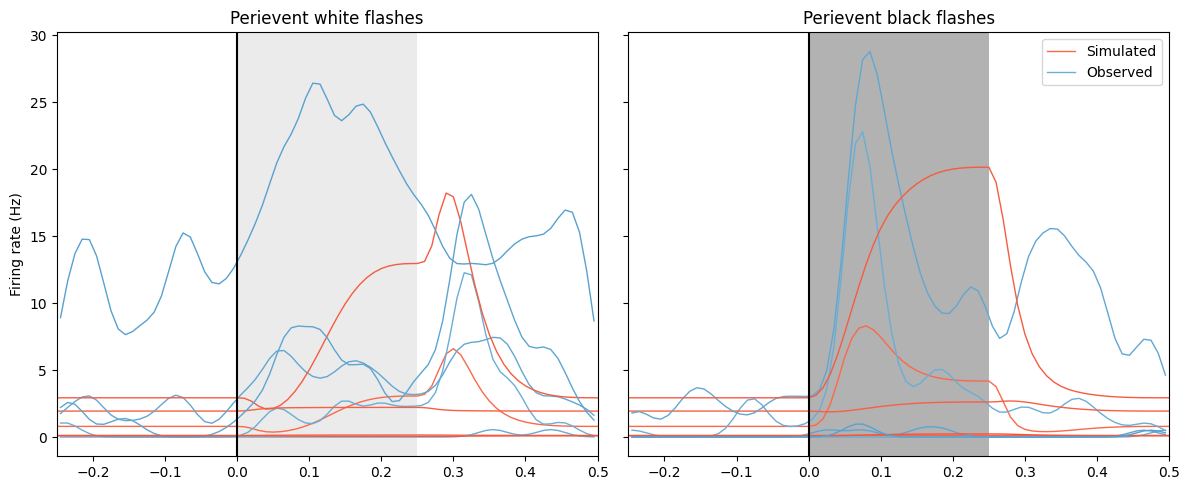

In [ ]:
plot_peri_both(params_obs_test,
               params_sim,
               bin_size,
               n_cells=5)

## Adding history as a new predictor

Question: can we use the spiking activity of other neurons to predict the spiking activity of a neuron?

In [27]:
# New basis
hist_bas = nmo.basis.RaisedCosineLogConv(
    n_basis_funcs=8, window_size=window_length, label="count_history"
)
stim_bas = bas

basis = stim_bas + hist_bas

X_hist_train = basis.compute_features(white_stimuli_train, black_stimuli_train, spikes_visp_subset_top_count_train)

X_hist_test = basis.compute_features(white_stimuli_test, black_stimuli_test, spikes_visp_subset_top_count_test)

/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'ArrayImpl'.
  warnings.warn(
/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'ArrayImpl'.
  warnings.warn(
/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'ArrayImpl'.
  warnings.warn(
/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'ArrayImpl'.
  warnings.warn(
/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 

In [28]:
# Fit with new basis as predictor
# Fitting pop model
reg_strength = 0.01 #This should be checked with cross validation

model_hist = nmo.glm.PopulationGLM(
    regularizer = "Ridge",
    regularizer_strength = reg_strength,
    solver_name="LBFGS", 
    solver_kwargs=dict(tol=10**-12))

model_hist.fit(X_hist_train,spikes_visp_subset_top_count_train)


PopulationGLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=Ridge(),
    regularizer_strength=0.01,
    solver_name='LBFGS',
    solver_kwargs={'tol': 1e-12}
)

/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'TsdFrame'.
  warnings.warn(


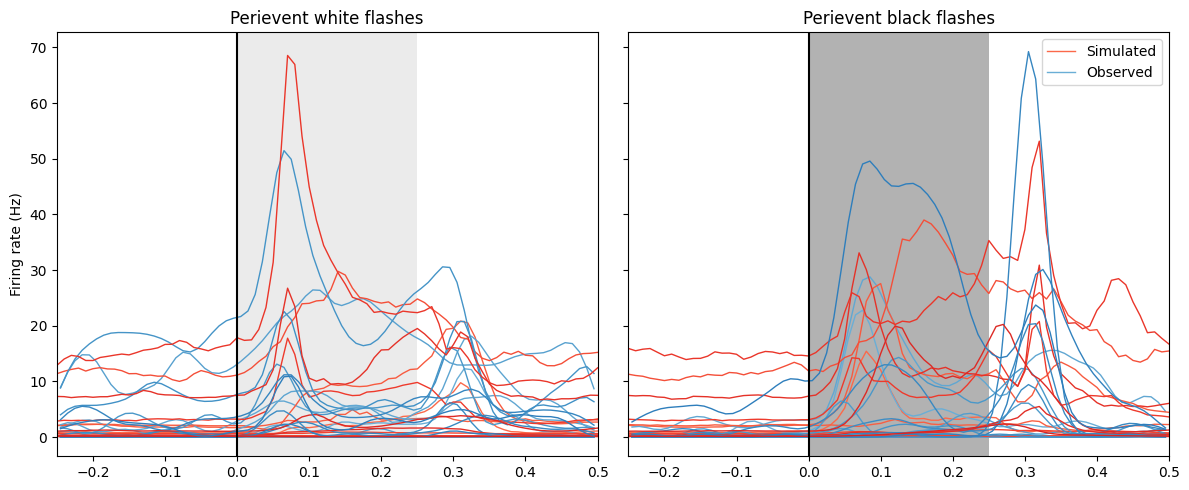

In [ ]:
pred_pop = model_hist.predict(X_hist_test)/ bin_size

pred_tsd_pop = nap.TsdFrame(t=spikes_visp_subset_top_count_test.t, d=pred_pop)

peri_white_sim, peri_black_sim = extract_perievents(pred_tsd_pop, flashes_test, continuous=True) 

# Excluding last trial from matrix because the last stimulus presented
# was a black one and after it's presented the time series is cut so
# it's all nans
peri_black_sim_new  = peri_black_sim[:,:-1,:]

params_sim = [peri_white_sim,
              range(peri_white_sim.shape[2]),
              peri_black_sim_new,
              range(peri_black_sim.shape[2])
              ]

plot_peri_both(params_obs_test,
               params_sim,
               bin_size,
               n_cells=15)

## Evaluate performance

In [30]:
def evaluate_model(model, X, y, label, dataset_type):
    score = model.score(X, y, score_type='pseudo-r2-McFadden')
    full_label = f"{label} ({dataset_type})"
    print(f"{full_label} score: {score:.4f}")
    return full_label, score, dataset_type

def evaluate_models(models, X_sets, y_sets, dataset_label, dataset_type, results):
    for model_name, model in models.items():
        X = X_sets[model_name]
        y = y_sets
        label = f"{model_name} model {dataset_label}"
        results.append(evaluate_model(model, X, y, label, dataset_type))

def evaluate_models_by_color(models, X_sets, y_sets, flashes, color,dataset_type, results):
    color_code = "1.0" if color == "white" else "-1.0"
    flashes_color = flashes[flashes["color"] == color_code]

    for model_name, model in models.items():
        X = X_sets[model_name].restrict(flashes_color)
        y = y_sets.restrict(flashes_color)
        label = f"{color} {model_name} model"
        results.append(evaluate_model(model, X, y, label, dataset_type))

# Store all results
all_results = []

# Define model dictionary
models = {
    "base": model_base,
    "hist": model_hist
}

# Evaluate full sets
evaluate_models(models, {"base": X_train, "hist": X_hist_train}, spikes_visp_subset_top_count_train, "train", "train", all_results)
evaluate_models(models, {"base": X_test, "hist": X_hist_test}, spikes_visp_subset_top_count_test, "test", "test", all_results)

# Evaluate by color
evaluate_models_by_color(models, {"base": X_train, "hist": X_hist_train}, spikes_visp_subset_top_count_train, flashes_train, "white", "train", all_results)
evaluate_models_by_color(models, {"base": X_train, "hist": X_hist_train}, spikes_visp_subset_top_count_train, flashes_train, "black", "train", all_results)

evaluate_models_by_color(models, {"base": X_test, "hist": X_hist_test}, spikes_visp_subset_top_count_test, flashes_test, "white", "test", all_results)
evaluate_models_by_color(models, {"base": X_test, "hist": X_hist_test}, spikes_visp_subset_top_count_test, flashes_test, "black",  "test", all_results)

# Get best models
best_train = max([r for r in all_results if r[2] == "train"], key=lambda x: x[1])
best_test = max([r for r in all_results if r[2] == "test"], key=lambda x: x[1])

print(f"\nBest TRAIN model: {best_train[0]} with score {best_train[1]:.4f}")
print(f"Best TEST model:  {best_test[0]} with score {best_test[1]:.4f}")


base model train (train) score: 0.0687
hist model train (train) score: 0.1356
base model test (test) score: 0.0335
hist model test (test) score: 0.0786
white base model (train) score: 0.0270
white hist model (train) score: 0.0967
black base model (train) score: 0.0179
black hist model (train) score: 0.1088
white base model (test) score: 0.0038
white hist model (test) score: 0.0466
black base model (test) score: -0.0199
black hist model (test) score: 0.0420

Best TRAIN model: hist model train (train) with score 0.1356
Best TEST model:  hist model test (test) with score 0.0786


- Probably this will look better if I have it in dict form
- Is the prediction so bad because the window for the black one should be larger?

Final remarks?

### References